In [ ]:
!wget -O IMDB.csv --no-check-certificate "https://docs.google.com/uc?export=download&id=1LSuaWB1tL-x_F7qkAL8gq3giVZEq5OHv"

--2020-10-20 18:08:32--  https://docs.google.com/uc?export=download&id=1LSuaWB1tL-x_F7qkAL8gq3giVZEq5OHv
Resolving docs.google.com (docs.google.com)... 108.177.112.113, 108.177.112.139, 108.177.112.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.112.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c7sb1h2ej7e98cdpb4iudhfhpmas36l2/1603217250000/03223631635386730136/*/1LSuaWB1tL-x_F7qkAL8gq3giVZEq5OHv?e=download [following]
--2020-10-20 18:08:39--  https://doc-10-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c7sb1h2ej7e98cdpb4iudhfhpmas36l2/1603217250000/03223631635386730136/*/1LSuaWB1tL-x_F7qkAL8gq3giVZEq5OHv?e=download
Resolving doc-10-0k-docs.googleusercontent.com (doc-10-0k-docs.googleusercontent.com)... 172.217.214.132, 2607:f8b0:4001:c05::84
Connecting to doc-10-0k-docs.googleusercontent.com (doc-10

In [ ]:
import pandas as pd 
df=pd.read_csv("IMDB.csv")
df.head(5)


#positive.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
positive =df['sentiment']=='positive'
positiverows=df[positive]
positiverows.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [ ]:
positive =df['sentiment']=='negative'
positiverows=df[positive]
positiverows.head(2)

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative


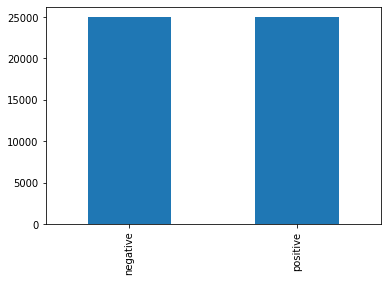

In [ ]:
valuecounts=df['sentiment'].value_counts()
valuecounts.head()
valuecounts.plot(kind='bar')

In [ ]:
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder


NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 128  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 128  # Maximum number of words in a sequence


In [ ]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history




def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    input_text=cleanhtml(input_text)
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

import re

def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return str(cleantext)
    



In [ ]:
import nltk
nltk.download('stopwords')
import numpy as np


df = df.reindex(np.random.permutation(df.index))  
df = df[['review', 'sentiment']]
df.review = df.review.apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 45000
# Test data samples: 5000


In [ ]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
len(X_train_seq)
#X_test_seq[0]

45000

In [ ]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    45000.000000
mean       129.808244
std         97.004738
min          4.000000
25%         70.000000
50%         97.000000
75%        158.000000
max       1501.000000
Name: review, dtype: float64

In [ ]:
X_train_seq_trunc = pad_sequences(X_train_seq,maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq,maxlen=MAX_LEN)
X_train_seq_trunc[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0, 8545,   86, 1074,
       6017,  489, 9197,   81, 2190, 1810, 1965,  955, 7216, 2155, 8545,
        106,  681,   46,  192,  965, 6827, 3287,  283,  114, 1234,  582,
        469,  560,   31, 5584,   40,  247, 4216,  548,  476,    3,  151,
       3714, 3015,  558, 1857,  154,   33,   31,   21, 2117, 2020,   26,
       1660, 2361,  126, 6294, 6530, 3594, 1242,  331,  517, 8545,  333,
         64,  232,   25,  648,  151,  837,  246, 1922, 1934,  117,    3,
         19,  608,   29, 4714,    4,  327, 1248], dtype=int32)

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le,num_classes=2)
y_test_oh = to_categorical(y_test_le,num_classes=2)
print(y_train_le[0])
print(y_train[0])



1
positive


In [ ]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation X set:',X_valid_emb.shape)
print('Shape of validation Y set:',y_valid_emb.shape)
print('Shape of train Y set:', y_train_emb.shape)
print('Shape of train X set:', X_train_emb.shape)

Shape of validation X set: (4500, 128)
Shape of validation Y set: (4500, 2)
Shape of train Y set: (40500, 2)
Shape of train X set: (40500, 128)


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
#from keras import models
#from keras import layers
#from keras import regularizers

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[] ,dtype=tf.string,trainable=True)

hub_layer(X_train)

emb_model = Sequential()

emb_model.add(layers.Embedding(NB_WORDS,4, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dropout(0.3))
emb_model.add(layers.Dense(16, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
#emb_model.add(layers.Dropout(0.2))
#emb_model.add(layers.Dense(16, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
emb_model.add(layers.Dense(8, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001,momentum=0)
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
import time
start_time = time.time()
    
emb_history = emb_model.fit(X_train_emb
                       , y_train_emb
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid_emb, y_valid_emb)
                       , verbose=1)
end_time = time.time()
#emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)


emb_model.summary()

Epoch 1/20
317/317 [==============================] - 1s 5ms/step - loss: 0.5654 - accuracy: 0.7203 - val_loss: 0.3528 - val_accuracy: 0.8631
Epoch 2/20
317/317 [==============================] - 1s 4ms/step - loss: 0.3064 - accuracy: 0.8832 - val_loss: 0.2887 - val_accuracy: 0.8924
Epoch 3/20
317/317 [==============================] - 1s 4ms/step - loss: 0.2627 - accuracy: 0.9029 - val_loss: 0.2876 - val_accuracy: 0.8904
Epoch 4/20
317/317 [==============================] - 1s 4ms/step - loss: 0.2396 - accuracy: 0.9132 - val_loss: 0.2811 - val_accuracy: 0.8909
Epoch 5/20
317/317 [==============================] - 1s 4ms/step - loss: 0.2264 - accuracy: 0.9177 - val_loss: 0.2825 - val_accuracy: 0.8882
Epoch 6/20
317/317 [==============================] - 1s 4ms/step - loss: 0.2147 - accuracy: 0.9240 - val_loss: 0.2855 - val_accuracy: 0.8884
Epoch 7/20
317/317 [==============================] - 1s 4ms/step - loss: 0.2068 - accuracy: 0.9266 - val_loss: 0.2898 - val_accuracy: 0.8887
Epoch 

In [ ]:

time_taken =  end_time - start_time
print("time_taken to train model :", time_taken, "seconds")

time_taken to train model : 26.623287200927734 seconds


Hidden units were decided after trial and error basis, inclusion or reduction did not boost model performance . 
L2 regularization is added to all layers
Dropout is added to the layer before relu activation to filter out unwanted properties. 0.30 value is added to force the output to be zero is the change is 30%
Hidden layers use Relu function and Output layer uses softmax as the output is a probability

In [ ]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

157/157 [==============================] - 0s 1ms/step - loss: 0.3305 - accuracy: 0.8838
/n
Test accuracy of word embeddings model: 88.38%


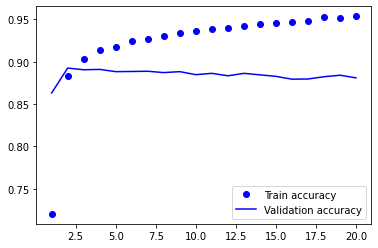

In [ ]:

import matplotlib.pyplot as plt
def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

eval_metric(emb_history, 'accuracy')

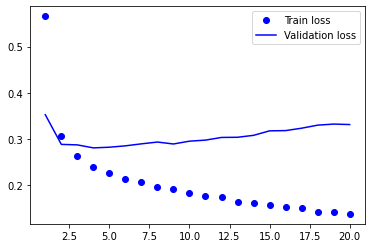

In [ ]:
eval_metric(emb_history, 'loss')

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

preds=np.argmax(emb_model.predict(X_test_seq_trunc),axis=-1)
#print(preds)
#print(y_test_le)
cf_matrix =confusion_matrix(y_test_le,preds)
print(cf_matrix)

[[2254  295]
 [ 286 2165]]


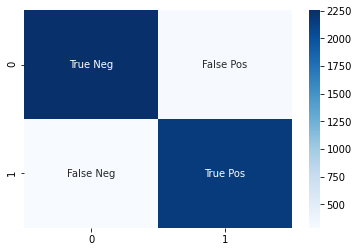

In [ ]:
import seaborn as sns
#sns.heatmap(cf_matrix, annot=True)
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true= y_test_le, y_pred=preds))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2549
           1       0.88      0.88      0.88      2451

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



Both the classes (0-> positive and 1-negetive) are approximately equally classified and missclassified .It might be due to ambiguous statements in the data . 

**HYPERPARAMATER TUNING **

In [ ]:
## CHANGED BATCH SIZE->64 IN THIS HYPERPARAMETER TUNING

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
#from keras import models
#from keras import layers
#from keras import regularizers



emb_model = Sequential()

emb_model.add(layers.Embedding(NB_WORDS,4, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dropout(0.3))
emb_model.add(layers.Dense(16, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
#emb_model.add(layers.Dropout(0.2))
#emb_model.add(layers.Dense(30, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
emb_model.add(layers.Dense(8, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001,momentum=0)
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
import time
start_time = time.time()
    
emb_history = emb_model.fit(X_train_emb
                       , y_train_emb
                       , epochs=NB_START_EPOCHS
                       , batch_size=64
                       , validation_data=(X_valid_emb, y_valid_emb)
                       , verbose=1)
end_time = time.time()
#emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)


emb_model.summary()


Epoch 1/20


633/633 [==============================] - 2s 3ms/step - loss: 0.5056 - accuracy: 0.7492 - val_loss: 0.3144 - val_accuracy: 0.8776
Epoch 2/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2947 - accuracy: 0.8867 - val_loss: 0.2834 - val_accuracy: 0.8893
Epoch 3/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2562 - accuracy: 0.9038 - val_loss: 0.2806 - val_accuracy: 0.8931
Epoch 4/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2329 - accuracy: 0.9160 - val_loss: 0.2844 - val_accuracy: 0.8907
Epoch 5/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2183 - accuracy: 0.9221 - val_loss: 0.2870 - val_accuracy: 0.8900
Epoch 6/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2084 - accuracy: 0.9257 - val_loss: 0.2926 - val_accuracy: 0.8898
Epoch 7/20
633/633 [==============================] - 2s 3ms/step - loss: 0.1977 - accuracy: 0.9299 - val_loss: 0.2972 - val_accuracy: 0.8864
Epoch 8/20
633/63

In [ ]:
results = emb_model.evaluate(X_test_seq_trunc, y_test_oh)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

157/157 [==============================] - 0s 1ms/step - loss: 0.3359 - accuracy: 0.8844
/n
Test accuracy of word embeddings model: 88.38%


In [ ]:
## CHANGED LEARNING RATE  IN THIS HYPERPARAMETER TUNING KEEPING BATCH SIZE 64

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
#from keras import models
#from keras import layers
#from keras import regularizers

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[] ,dtype=tf.string,trainable=True)

hub_layer(X_train)

emb_model = Sequential()

emb_model.add(layers.Embedding(NB_WORDS,4, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dropout(0.3))
emb_model.add(layers.Dense(16, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
#emb_model.add(layers.Dropout(0.2))
#emb_model.add(layers.Dense(30, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
emb_model.add(layers.Dense(8, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01,momentum=0)
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
import time
start_time = time.time()
    
emb_history = emb_model.fit(X_train_emb
                       , y_train_emb
                       , epochs=NB_START_EPOCHS
                       , batch_size=64
                       , validation_data=(X_valid_emb, y_valid_emb)
                       , verbose=1)
end_time = time.time()
#emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)


emb_model.summary()

Epoch 1/20
633/633 [==============================] - 2s 3ms/step - loss: 0.3930 - accuracy: 0.8353 - val_loss: 0.3106 - val_accuracy: 0.8807
Epoch 2/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2848 - accuracy: 0.8946 - val_loss: 0.2965 - val_accuracy: 0.8900
Epoch 3/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2594 - accuracy: 0.9057 - val_loss: 0.3005 - val_accuracy: 0.8880
Epoch 4/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2434 - accuracy: 0.9125 - val_loss: 0.3054 - val_accuracy: 0.8862
Epoch 5/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2326 - accuracy: 0.9177 - val_loss: 0.3143 - val_accuracy: 0.8807
Epoch 6/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2254 - accuracy: 0.9207 - val_loss: 0.3135 - val_accuracy: 0.8876
Epoch 7/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2209 - accuracy: 0.9229 - val_loss: 0.2970 - val_accuracy: 0.8851
Epoch 

In [ ]:
results = emb_model.evaluate(X_test_seq_trunc, y_test_oh)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(results[1]*100))

157/157 [==============================] - 0s 1ms/step - loss: 0.3258 - accuracy: 0.8850
/n
Test accuracy of word embeddings model: 88.50%


In [ ]:
## CHANGED LEARNING RATE  IN THIS HYPERPARAMETER TUNING KEEPING BATCH SIZE 64 AND training without regularisation

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
#from keras import models
#from keras import layers
#from keras import regularizers

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[] ,dtype=tf.string,trainable=True)

hub_layer(X_train)

emb_model = Sequential()

emb_model.add(layers.Embedding(NB_WORDS,4, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dropout(0.3))
emb_model.add(layers.Dense(60, activation = 'relu'))
#emb_model.add(layers.Dropout(0.2))
emb_model.add(layers.Dense(30, activation = 'relu'))
emb_model.add(layers.Dense(16, activation = 'relu'))
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01,momentum=0)
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
import time
start_time = time.time()
    
emb_history = emb_model.fit(X_train_emb
                       , y_train_emb
                       , epochs=NB_START_EPOCHS
                       , batch_size=64
                       , validation_data=(X_valid_emb, y_valid_emb)
                       , verbose=1)
end_time = time.time()
#emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)


emb_model.summary()

Epoch 1/20
633/633 [==============================] - 2s 4ms/step - loss: 0.3859 - accuracy: 0.8178 - val_loss: 0.2737 - val_accuracy: 0.8851
Epoch 2/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2640 - accuracy: 0.8942 - val_loss: 0.2704 - val_accuracy: 0.8856
Epoch 3/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2276 - accuracy: 0.9106 - val_loss: 0.2908 - val_accuracy: 0.8816
Epoch 4/20
633/633 [==============================] - 2s 3ms/step - loss: 0.2059 - accuracy: 0.9212 - val_loss: 0.2905 - val_accuracy: 0.8849
Epoch 5/20
633/633 [==============================] - 2s 3ms/step - loss: 0.1927 - accuracy: 0.9266 - val_loss: 0.2899 - val_accuracy: 0.8902
Epoch 6/20
633/633 [==============================] - 2s 3ms/step - loss: 0.1798 - accuracy: 0.9327 - val_loss: 0.2902 - val_accuracy: 0.8831
Epoch 7/20
633/633 [==============================] - 2s 3ms/step - loss: 0.1691 - accuracy: 0.9380 - val_loss: 0.3303 - val_accuracy: 0.8811
Epoch 

In [ ]:
results = emb_model.evaluate(X_test_seq_trunc, y_test_oh)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(results[1]*100))

157/157 [==============================] - 0s 1ms/step - loss: 0.6626 - accuracy: 0.8690
/n
Test accuracy of word embeddings model: 86.90%


**MODEL CREATION USING PRETRAINED WEIGHTS **

In [ ]:


hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

# if I add hub layer then i get shape error ,
#embedded = hub_layer(tf.reshape(df.review[:10000]))
embedded=hub_layer(df.review[:10000])
#embedded=tf.reshape(embedded,[:4])
#embedded = hub_layer(df.review[:10000])
print(embedded)
embedding_layer = layers.Embedding(10000,
                            128,
                            weights=[embedded],
                            input_length=MAX_LEN,
                            trainable=False)

emb_model = Sequential()
emb_model.add(embedding_layer)
emb_model.add(layers.Flatten())
emb_model.add(layers.Dropout(0.3))
emb_model.add(layers.Dense(8, activation = 'relu'))
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01,momentum=.25)
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
import time
start_time = time.time()
    
emb_history = emb_model.fit(X_train_emb
                       , y_train_emb
                       , epochs=5
                       , batch_size=64
                       , validation_data=(X_valid_emb, y_valid_emb)
                       , verbose=1)
end_time = time.time()
#emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)


emb_model.summary()

tf.Tensor(
[[ 0.2286596   0.1567697   0.04163042 ... -0.05484968  0.09114031
   0.18645424]
 [ 0.24344252 -0.00834238  0.09855147 ... -0.34181222  0.14829344
   0.2064092 ]
 [ 0.28259435  0.10403575  0.09568932 ... -0.17417295  0.15409155
   0.11913329]
 ...
 [-0.24940245  0.10744675  0.01557767 ... -0.07574641  0.0377127
   0.02313053]
 [-0.03606247  0.07361308 -0.05847034 ... -0.3309123   0.08151184
  -0.1181119 ]
 [ 0.25184613  0.06969944 -0.03010845 ... -0.48930988  0.33697847
   0.18310215]], shape=(10000, 128), dtype=float32)
Epoch 1/5
633/633 [==============================] - 14s 22ms/step - loss: 0.7393 - accuracy: 0.5013 - val_loss: 0.6946 - val_accuracy: 0.4960
Epoch 2/5
633/633 [==============================] - 13s 21ms/step - loss: 0.6935 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5040
Epoch 3/5
633/633 [==============================] - 13s 21ms/step - loss: 0.6935 - accuracy: 0.5023 - val_loss: 0.6934 - val_accuracy: 0.4960
Epoch 4/5
633/633 [==============

In [ ]:
#emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)

results = emb_model.evaluate(X_test_seq_trunc, y_test_oh)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(results[1]*100))

157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4980
/n
Test accuracy of word embeddings model: 49.80%
